# Installing the libraries and all the Imports

In [1]:
!python --version


Python 3.12.12


In [2]:
# --- Install the required library ---
!pip install compressai

# --- All necessary imports ---
import os
import io
import math
import time
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg19

# --- CompressAI Imports ---
from compressai.layers import GDN, AttentionBlock, ResidualBlock
from compressai.entropy_models import EntropyBottleneck, GaussianConditional
from compressai.models.utils import conv, deconv



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hyperparameters and the device setup

In [4]:
# --- Setup GPU device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Dataset and Training Parameters ---
BATCH_SIZE = 8  # From your notes
PATCH_SIZE = 64 # Your 64x64 image size
TRAIN_PATH = "/content/drive/MyDrive/Collab_Data/complex_data"
TEST_PATH = "/content/drive/MyDrive/Collab_Data/complex_test" # For final comparison

# --- Model Architecture Parameters (Chapter 3) ---
# N=256 for main convs, M=448 for bottleneck (from Figure 3.12)
NUM_FILTERS_N = 256
NUM_FILTERS_M = 448

# --- Optimizer Parameters (Section 3.1.2) ---
LEARNING_RATE = 1e-4  #
BETA_1 = 0.9          #
BETA_2 = 0.999        #

# --- Loss Function Parameters (Section 3.4.1) ---
# *** REMOVED LAMBDA_A_MSE and LAMBDA_B_VGG ***
# The AutomaticLossBalancer makes them redundant and causes explosions.

# --- Training Loop Parameters ---
NUM_EPOCHS = 300 # A good target
# (5000 images / 8 batch size) = 625 steps

SAVE_PATH = "/content/drive/MyDrive/AI_Models/Images_project/Improvement_3/model.pth"

Using device: cpu


# Data Loading & Augmentation


Loaded 5500 total training images.
Split into: 4400 training & 1100 validation images.
Loaded 11 test images.

Visualizing one augmented 64x64 batch:


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


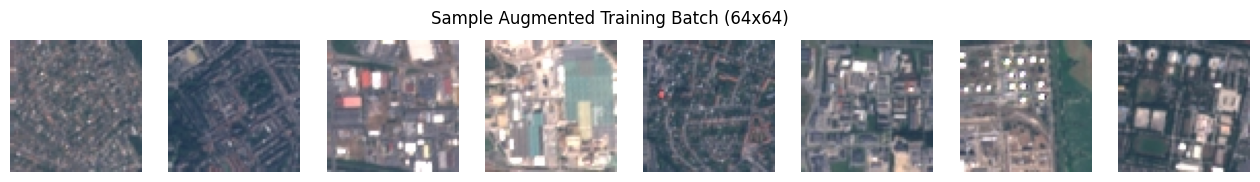

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split # Import random_split
from PIL import Image
import os
import matplotlib.pyplot as plt
from torchvision import transforms

# --- Define Augmentations ---
train_transforms = transforms.Compose([
    transforms.RandomRotation([90, 90]),  # pi/2 rotation
    transforms.RandomAffine(degrees=0, shear=[-15, 15, -15, 15]),  # Shear mapping
    transforms.ToTensor(),  # Converts to [0, 1] float tensor
])

# For validation and testing, we just convert to tensor.
val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# --- Custom Dataset for Flat Folder (Unchanged) ---
class FlatImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [
            f for f in os.listdir(root_dir)
            if os.path.isfile(os.path.join(root_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0

# --- Create Datasets and DataLoaders ---
try:
    # 1. Load the full training dataset
    full_train_dataset = FlatImageDataset(TRAIN_PATH, transform=train_transforms)

    # 2. Define split sizes (e.g., 80% train, 20% validation)
    VAL_SPLIT = 0.2
    val_size = int(len(full_train_dataset) * VAL_SPLIT)
    train_size = len(full_train_dataset) - val_size

    # 3. Create the splits
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    # 4. Create the test dataset (with validation transforms)
    # We also apply the simpler transform to the val_dataset
    val_dataset.dataset.transform = val_test_transforms
    test_dataset = FlatImageDataset(TEST_PATH, transform=val_test_transforms)

    # 5. Create DataLoaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=2,
        shuffle=True,
        pin_memory=True,
        drop_last=True,
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE, # Use the same batch size
        num_workers=2,
        shuffle=False, # No need to shuffle validation
        pin_memory=True,
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        num_workers=2,
        shuffle=False,
        pin_memory=True,
    )

    print(f"Loaded {len(full_train_dataset)} total training images.")
    print(f"Split into: {len(train_dataset)} training & {len(val_dataset)} validation images.")
    print(f"Loaded {len(test_dataset)} test images.")

    # --- Visualize one batch to confirm ---
    print("\nVisualizing one augmented 64x64 batch:")
    img_batch, _ = next(iter(train_dataloader))
    fig, axes = plt.subplots(1, BATCH_SIZE, figsize=(16, 2))
    for i in range(BATCH_SIZE):
        img = img_batch[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.suptitle("Sample Augmented Training Batch (64x64)")
    plt.show()

except FileNotFoundError:
    print("---! ERROR !---")
    print(f"Could not find the dataset path: {TRAIN_PATH} or {TEST_PATH}")
    print("Please ensure your Google Drive is mounted and the paths in Cell 4 are correct.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please check your data paths and file integrity.")

# Attention Module

In [6]:
# The paper's Attention Module (Figure 2.4 / 3.12) is a
# Squeeze-and-Excitation block.
# We can use the optimized, pre-built version from compressai.
CustomAttentionBlock = AttentionBlock
print("Using compressai.layers.AttentionBlock as the Attention Module.")

Using compressai.layers.AttentionBlock as the Attention Module.


# The VBR Autoencoder Model Core

In [7]:
class SatelliteVBR(nn.Module):
    """
    Full VBR Autoencoder model implementing all features from Chapter 3.
    This architecture is fully convolutional and will adapt to 64x64 inputs.
    g_a(64x64) -> y(4x4)
    h_a(y, 4x4) -> z(1x1)
    """
    def __init__(self, N=NUM_FILTERS_N, M=NUM_FILTERS_M):
        super().__init__()

        # --- Main Encoder (g_a) ---
        # 3x3 kernels, stride 2, 4 layers
        self.g_a = nn.Sequential(
            conv(3, N, kernel_size=3, stride=2),
            GDN(N), # Simplified GDN (Sec 3.2.2.3) [cite: 1175-1186]
            conv(N, N, kernel_size=3, stride=2),
            GDN(N),
            CustomAttentionBlock(N), # Attention Module (Sec 3.3.2) [cite: 1278-1286]
            conv(N, N, kernel_size=3, stride=2),
            GDN(N),
            conv(N, M, kernel_size=3, stride=2),
            CustomAttentionBlock(M), # Attention Module (Sec 3.3.2)
        )

        # --- Main Decoder (g_s) ---
        self.g_s = nn.Sequential(
            CustomAttentionBlock(M), # Attention Module
            deconv(M, N, kernel_size=3, stride=2),
            GDN(N, inverse=True),
            CustomAttentionBlock(N), # Attention Module
            deconv(N, N, kernel_size=3, stride=2),
            GDN(N, inverse=True),
            deconv(N, N, kernel_size=3, stride=2),
            GDN(N, inverse=True),
            deconv(N, 3, kernel_size=3, stride=2),
        )

        # --- Hyperprior (h_a and h_s) ---
        # *** FIX 1: Using LeakyReLU for better stability than ReLU ***
        self.h_a = nn.Sequential(
            conv(M, N, kernel_size=3, stride=1), # 3x3 kernel
            nn.LeakyReLU(inplace=True),
            conv(N, N, kernel_size=3, stride=2), # 3x3 kernel
            nn.LeakyReLU(inplace=True),
            conv(N, N, kernel_size=3, stride=2), # 3x3 kernel
        )

        self.h_s = nn.Sequential(
            deconv(N, N, kernel_size=3, stride=2),
            nn.LeakyReLU(inplace=True),
            deconv(N, N, kernel_size=3, stride=2),
            nn.LeakyReLU(inplace=True),
            deconv(N, M * 2, kernel_size=3, stride=1), # Output 2*M for mean and log_scale
        )

        # --- Entropy Models (from compressai) ---
        self.entropy_bottleneck = EntropyBottleneck(N)
        self.gaussian_conditional = GaussianConditional(None) # None for variable scales

    def forward(self, x, gain):
        """
        Forward pass with Variable Bit Rate (VBR) Gain Unit. [cite: 1045-1050]
        'gain' is a [B, 1, 1, 1] tensor.
        """
        # --- VBR Gain Unit (Encoder) ---
        y = self.g_a(x)
        y_scaled = y * gain # This is the Gain Unit

        # --- Hyperprior Path ---
        z = self.h_a(y)
        z_hat, z_likelihoods = self.entropy_bottleneck(z)

        # Hyperprior decoder predicts mean and log_scale
        mean_scale = self.h_s(z_hat)
        mean, log_scale = mean_scale.chunk(2, 1) # Split M*2 into M (mean) and M (log_scale)

        # --- *** FIX 2: Exponentiate log_scale to get positive scale *** ---
        # This is the critical fix to prevent NaN.
        scale = torch.exp(log_scale)

        # --- Main Bottleneck Path ---
        y_hat_scaled, y_likelihoods = self.gaussian_conditional(y_scaled, scale, mean)

        # --- VBR Inverse Gain Unit (Decoder) ---
        y_hat = y_hat_scaled / gain

        x_hat = self.g_s(y_hat)

        return {
            "x_hat": x_hat,
            "likelihoods": {
                "y": y_likelihoods,
                "z": z_likelihoods,
            },
        }

# Perceptual Loss (VGG) Module

In [8]:
class VggPerceptualLoss(nn.Module):
    """
    Implements the perceptual loss (P)
    Uses early layers of VGG19.
    """
    def __init__(self):
        super(VggPerceptualLoss, self).__init__()
        vgg = vgg19(pretrained=True).features.to(device)
        vgg.eval()
        for param in vgg.parameters():
            param.requires_grad = False

        # Extract features from layers at "depths 2 and 4"
        # This corresponds to relu_2_2 (layer 9) and relu_4_2 (layer 27)
        self.features = nn.Sequential(
            *list(vgg.children())[:28]
        )
        self.feature_layers = [9, 27] # Indices for relu_2_2 and relu_4_2

        # VGG expects normalized input
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def forward(self, x_true, x_pred):
        x_true_norm = self.normalize(x_true)
        x_pred_norm = self.normalize(x_pred)

        loss = 0.0
        features_true = x_true_norm
        features_pred = x_pred_norm

        for i, layer in enumerate(self.features):
            features_true = layer(features_true)
            features_pred = layer(features_pred)

            if i in self.feature_layers:
                loss += F.mse_loss(features_true, features_pred)

        return loss

# Full Loss Function & Balancer

In [9]:
class AutomaticLossBalancer(nn.Module):
    """
    Implements the multi-loss balancing strategy from Sec 3.4.2, Eq 3.8
    This module is stateful.
    """
    def __init__(self, num_losses=2, T=2.0):
        super().__init__()
        self.num_losses = num_losses
        self.T = T
        # We register them as buffers so they are saved with the model state
        self.register_buffer("prev_losses", torch.ones(num_losses))
        self.register_buffer("prev_prev_losses", torch.ones(num_losses))

    def forward(self, current_losses_detached):
        # current_losses_detached is a *detached* tensor [L_mse, L_vgg]

        # wk = Lk(t-1) / Lk(t-2)
        w = self.prev_losses / (self.prev_prev_losses + 1e-6)

        # lambda_k = ...
        exp_w = torch.exp(w / self.T)
        sum_exp_w = torch.sum(exp_w)
        lambdas = (self.num_losses * exp_w) / sum_exp_w

        # Update history
        self.prev_prev_losses = self.prev_losses.clone()
        self.prev_losses = current_losses_detached.clone()

        return lambdas

class RateDistortionPerceptionLoss(nn.Module):
    """
    Full loss function L = (lambda_D * L_D + lambda_P * L_P) + alpha * R
    Based on Eq 3.7
    """
    def __init__(self):
        super().__init__()
        self.vgg_loss_fn = VggPerceptualLoss()

    def forward(self, x, out_net, lambda_mse, lambda_vgg, lambda_rate):
        x_hat = out_net["x_hat"]
        likelihoods = out_net["likelihoods"]
        num_pixels = x.size(0) * x.size(2) * x.size(3)

        # --- Rate Loss (R) ---
        rate_y = torch.log(likelihoods["y"]).sum() / (-math.log(2) * num_pixels)
        rate_z = torch.log(likelihoods["z"]).sum() / (-math.log(2) * num_pixels)
        rate_loss = rate_y + rate_z

        # --- Distortion Losses (D and P) ---
        # *** FIX: We use the RAW losses, not the scaled ones ***
        L_mse_raw = F.mse_loss(x, x_hat)
        L_vgg_raw = self.vgg_loss_fn(x, x_hat)

        # --- Total Loss (Eq 3.7) ---
        # The auto-balancer weights (lambda_mse, lambda_vgg) are now
        # applied to the raw losses.
        distortion_loss = (lambda_mse * L_mse_raw) + (lambda_vgg * L_vgg_raw)
        total_loss = distortion_loss + (lambda_rate * rate_loss)

        return {
            "loss": total_loss,
            "rate_bpp": rate_loss,
            "mse": L_mse_raw, # Return raw MSE
            "psnr": -10 * torch.log10(L_mse_raw),
            "vgg_loss": L_vgg_raw, # Return raw VGG
            "L_mse_weighted": L_mse_raw * lambda_mse, # For logging
            "L_vgg_weighted": L_vgg_raw * lambda_vgg  # For logging
        }

# Training Setup

In [11]:
# --- Instantiate Model and Helpers ---
model = SatelliteVBR(N=NUM_FILTERS_N, M=NUM_FILTERS_M).to(device)
criterion = RateDistortionPerceptionLoss().to(device)
balancer = AutomaticLossBalancer().to(device)

# --- Setup Optimizer ---
optimizer = Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(BETA_1, BETA_2) #
)

# --- Setup LR Scheduler (Sec 3.1.2) ---
# halved when the evaluation loss reaches a plateau of 10 epochs"
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5, # "halved"
    patience=10  # "plateau of 10 epochs"
)

print(f"Model, Loss, and Optimizer are ready for {PATCH_SIZE}x{PATCH_SIZE} images.")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 77.2MB/s]


Model, Loss, and Optimizer are ready for 64x64 images.


# Training Loop

In [ ]:
from compressai.utils.eval_model.__main__ import psnr as compute_psnr
import time
import numpy as np

print("--- Starting Training (Fixed BPP Mode with Validation) ---")
best_loss = float('inf') # We now track the best *validation* loss

# --- History lists for plotting ---
history = {
    "train_loss": [],
    "train_psnr": [],
    "train_bpp": [],
    "val_loss": [],
    "val_psnr": [],
    "val_bpp": []
}
# ----------------------------------

# --- SET YOUR FIXED TARGETS HERE ---
# To target ~2.0 bpp (based on the paper), let's use 0.5
TARGET_LAMBDA_RATE = 0.8

# Set a fixed gain. 1.0 is a neutral value.
TARGET_GAIN = 1.0
gain = torch.tensor([TARGET_GAIN]).view(1, 1, 1, 1).to(device)
lambda_rate = TARGET_LAMBDA_RATE

print(f"Training with FIXED Lambda_Rate: {lambda_rate} and FIXED Gain: {TARGET_GAIN}")
# --- END OF NEW ---


for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # --- Training Phase ---
    model.train() # Set model to training mode
    epoch_loss = 0
    epoch_psnr = 0
    epoch_bpp = 0

    # We now iterate over the *entire* train_dataloader
    for i, (batch, _) in enumerate(train_dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()

        # --- Forward Pass ---
        # Use the fixed gain tensor (broadcasted to batch size)
        out_net = model(batch, gain.expand(batch.size(0), -1, -1, -1))

        # --- Loss Calculation ---
        with torch.no_grad(): # Balancer logic should not be part of graph
            L_mse_raw = F.mse_loss(batch, out_net["x_hat"])
            L_vgg_raw = criterion.vgg_loss_fn(batch, out_net["x_hat"])
            lambdas = balancer(torch.stack([L_mse_raw, L_vgg_raw]))
            lambda_mse, lambda_vgg = lambdas[0], lambdas[1]

        metrics = criterion(
            batch,
            out_net,
            lambda_mse=lambda_mse,
            lambda_vgg=lambda_vgg,
            lambda_rate=lambda_rate  # Use the fixed lambda_rate
        )

        # --- Backpropagation ---
        if torch.isnan(metrics["loss"]):
            print(f"Step {i}: Loss is NaN. Skipping step.")
            optimizer.zero_grad()
            continue

        metrics["loss"].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # --- Log Metrics ---
        epoch_loss += metrics["loss"].item()
        epoch_psnr += metrics["psnr"].item()
        epoch_bpp += metrics["rate_bpp"].item()

    # --- End of Training Phase ---
    avg_loss = epoch_loss / len(train_dataloader)
    avg_psnr = epoch_psnr / len(train_dataloader)
    avg_bpp = epoch_bpp / len(train_dataloader)


    # --- NEW: Validation Phase ---
    model.eval() # Set model to evaluation mode
    epoch_val_loss = 0
    epoch_val_psnr = 0
    epoch_val_bpp = 0

    with torch.no_grad():
        for batch, _ in val_dataloader:
            batch = batch.to(device)

            # Forward pass with fixed gain
            out_net = model(batch, gain.expand(batch.size(0), -1, -1, -1))

            # Loss calculation
            # We use the *same* balancer state, but don't update its history
            # (as it's only meant to track training loss trends)
            L_mse_raw = F.mse_loss(batch, out_net["x_hat"])
            L_vgg_raw = criterion.vgg_loss_fn(batch, out_net["x_hat"])
            lambdas = balancer(torch.stack([L_mse_raw, L_vgg_raw]))
            lambda_mse, lambda_vgg = lambdas[0], lambdas[1]

            metrics = criterion(
                batch,
                out_net,
                lambda_mse=lambda_mse,
                lambda_vgg=lambda_vgg,
                lambda_rate=lambda_rate
            )

            if not torch.isnan(metrics["loss"]):
                epoch_val_loss += metrics["loss"].item()
                epoch_val_psnr += metrics["psnr"].item()
                epoch_val_bpp += metrics["rate_bpp"].item()

    # --- End of Validation Phase ---
    avg_val_loss = epoch_val_loss / len(val_dataloader)
    avg_val_psnr = epoch_val_psnr / len(val_dataloader)
    avg_val_bpp = epoch_val_bpp / len(val_dataloader)
    epoch_time = time.time() - epoch_start_time


     # --- Capture metrics for plotting ---
    history["train_loss"].append(avg_loss)
    history["train_psnr"].append(avg_psnr)
    history["train_bpp"].append(avg_bpp)
    history["val_loss"].append(avg_val_loss)
    history["val_psnr"].append(avg_val_psnr)
    history["val_bpp"].append(avg_val_bpp)
# ------------------------------------

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} ({epoch_time:.2f}s) - LR: {optimizer.param_groups[0]['lr']:.1e}")
    print(f"  TRAIN -> Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f} dB, BPP: {avg_bpp:.3f}")
    print(f"  VALID -> Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.2f} dB, BPP: {avg_val_bpp:.3f}")

    # --- LR Scheduler & Checkpointing (NOW USES VALIDATION LOSS) ---
    scheduler.step(avg_val_loss) # Step based on validation loss

    if avg_val_loss < best_loss and not np.isnan(avg_val_loss):
        best_loss = avg_val_loss
        print(f"  -> New best VALIDATION loss: {best_loss:.4f}. Saving checkpoint to {SAVE_PATH}")
        torch.save(model.state_dict(), SAVE_PATH)

print("\n--- Training Complete ---")

In [12]:
import matplotlib.pyplot as plt

# Assuming 'history' is the dictionary you populated during training
# history = {
#     "train_loss": [...], "train_psnr": [...], "train_bpp": [...],
#     "val_loss": [...], "val_psnr": [...], "val_bpp": [...]
# }

# Determine the number of epochs (length of any metric list)
epochs = range(1, len(history['train_loss']) + 1)

# --- Create the plots ---

# Set up a figure with 3 subplots, 1 row, 3 columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# 1. Plot Loss
ax1.plot(epochs, history['train_loss'], 'bo-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# 2. Plot PSNR (Peak Signal-to-Noise Ratio)
ax2.plot(epochs, history['train_psnr'], 'bo-', label='Train PSNR')
ax2.plot(epochs, history['val_psnr'], 'ro-', label='Validation PSNR')
ax2.set_title('PSNR vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('PSNR (dB)')
ax2.legend()
ax2.grid(True)

# 3. Plot BPP (Bits Per Pixel)
ax3.plot(epochs, history['train_bpp'], 'bo-', label='Train BPP')
ax3.plot(epochs, history['val_bpp'], 'ro-', label='Validation BPP')
ax3.set_title('BPP vs. Epochs')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('BPP')
ax3.legend()
ax3.grid(True)

# --- Display the plots ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

# If you are in a Jupyter Notebook, you might just run:
# %matplotlib inline
# (at the top of your cell) and the plots will appear automatically after plt.show()

NameError: name 'history' is not defined

Loading model from /content/drive/MyDrive/AI_Models/Images_project/Improvement_3/model.pth...
Successfully loaded best model weights.

Found 11 test images. Running inference and metrics...
Processed Residential_56.jpg...
Processed Residential_49.jpg...
Processed Residential_40.jpg...
Processed Residential_18.jpg...
Processed Residential_2.jpg...
Processed Residential_25.jpg...
Processed Residential_6.jpg...
Processed Residential_37.jpg...
Processed Residential_26.jpg...
Processed Residential_31.jpg...
Processed Residential_12.jpg...

Saved comparison plot to reconstruction_comparison_with_jpeg.png

--- Evaluation Complete ---
Your Model (Variable Rate, GAIN=1.0):
  Average PSNR: 28.6532 dB
  Average SSIM: 0.8892
  Average BPP:  1.9553 bpp

Standard JPEG (Targeting 2.0 BPP):
  Average PSNR: 25.6412 dB
  Average SSIM: 0.7806
  Average BPP:  1.9840 bpp


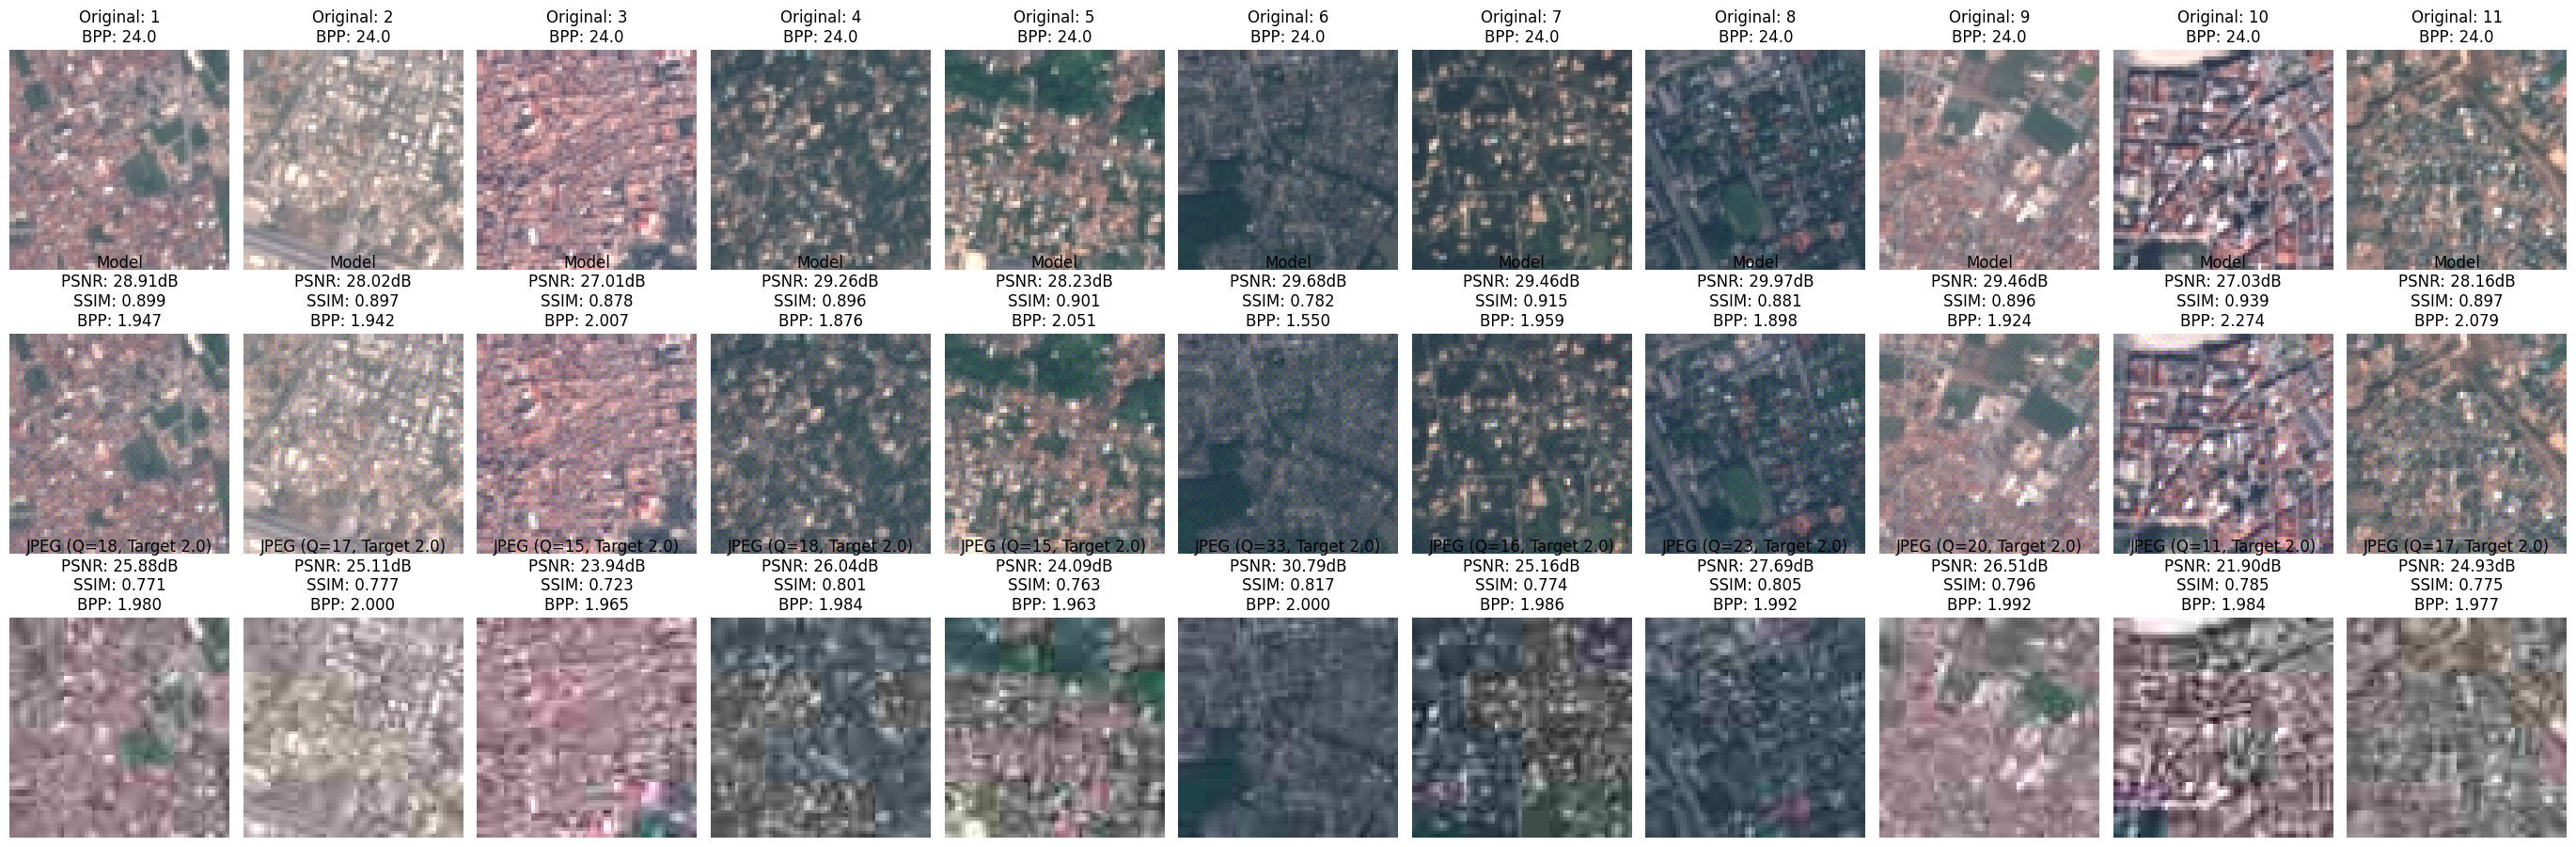

In [13]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import math
import torch.nn.functional as F
import pytorch_msssim # We can use this since compressai installed it
import io # Required for in-memory JPEG compression

# --- Helper function for PSNR (for tensors in [0, 1] range) ---
def compute_psnr(a, b):
    mse = torch.mean((a - b) ** 2).item()
    if mse == 0:
        return float('inf')
    return -10 * math.log10(mse)

# --- NEW Helper function to get JPEG at a target BPP ---
def get_jpeg_at_bpp(image_pil, target_bpp, num_pixels):
    """
    Compresses a PIL image to JPEG, iteratively finding the highest
    quality (Q) that results in a BPP at or below the target_bpp.
    """
    target_bytes = (num_pixels * target_bpp) / 8.0

    # Search for the best quality setting (100 down to 1)
    for quality in range(100, 0, -1):
        buffer = io.BytesIO() # Create an in-memory buffer
        image_pil.save(buffer, format="JPEG", quality=quality)
        file_size = buffer.tell() # Get size in bytes

        if file_size <= target_bytes:
            # This is the highest quality at or below the target BPP
            actual_bpp = (file_size * 8) / num_pixels
            jpeg_image_pil = Image.open(buffer)
            return jpeg_image_pil, actual_bpp, quality

    # If target is too low (even quality=1 is too big)
    buffer = io.BytesIO()
    image_pil.save(buffer, format="JPEG", quality=1)
    file_size = buffer.tell()
    actual_bpp = (file_size * 8) / num_pixels
    jpeg_image_pil = Image.open(buffer)
    return jpeg_image_pil, actual_bpp, 1

# --- 1. Load your trained model ---
print(f"Loading model from {SAVE_PATH}...")
inference_model = SatelliteVBR(N=NUM_FILTERS_N, M=NUM_FILTERS_M).to(device)

try:
    state_dict = torch.load(SAVE_PATH, map_location=device)
    inference_model.load_state_dict(state_dict, strict=False)
    inference_model.eval()
    print("Successfully loaded best model weights.\n")

    # --- 2. Get all test images ---
    test_images = [f for f in os.listdir(TEST_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not test_images:
        raise FileNotFoundError(f"No images found in {TEST_PATH}")

    num_images = len(test_images)
    print(f"Found {num_images} test images. Running inference and metrics...")

    # --- 3. Create the plot grid (MODIFIED FOR 3 ROWS) ---
    fig, axes = plt.subplots(3, num_images, figsize=(num_images * 2.5, 9)) # 9 inches high for 3 rows

    # --- Targets ---
    TARGET_GAIN = 1.0 # For the model
    TARGET_BPP_JPEG = 2 # For JPEG <-- This line was changed

    gain_tensor = torch.tensor([TARGET_GAIN]).view(1, 1, 1, 1).to(device)

    # Lists for model metrics
    model_psnr_scores = []
    model_ssim_scores = []
    model_bpp_scores = []

    # NEW lists for JPEG metrics
    jpeg_psnr_scores = []
    jpeg_ssim_scores = []
    jpeg_bpp_scores = []

    # --- 4. Loop, Infer, and Calculate Metrics ---
    for idx, filename in enumerate(test_images):
        test_image_path = os.path.join(TEST_PATH, filename)
        original_image_pil = Image.open(test_image_path).convert("RGB")
        original_image_tensor = test_transforms(original_image_pil).unsqueeze(0).to(device)

        num_pixels = original_image_tensor.size(2) * original_image_tensor.size(3)
        original_bpp = 24.0 # 8 bits * 3 channels

        # --- Plot Original Image (Row 1) ---
        axes[0, idx].imshow(original_image_pil)
        axes[0, idx].set_title(f"Original: {idx+1}\nBPP: {original_bpp:.1f}")
        axes[0, idx].axis("off")

        # --- Model Reconstruction (Row 2) ---
        with torch.no_grad():
            output_dict = inference_model(original_image_tensor, gain_tensor)
            recon_image_model = output_dict["x_hat"].clamp_(0, 1)

            # Calculate metrics for Model
            model_psnr_val = compute_psnr(recon_image_model, original_image_tensor)
            model_ssim_val = pytorch_msssim.ssim(recon_image_model, original_image_tensor, data_range=1.0).item()

            likelihoods = output_dict["likelihoods"]
            rate_y = torch.log(likelihoods["y"]).sum() / (-math.log(2) * num_pixels)
            rate_z = torch.log(likelihoods["z"]).sum() / (-math.log(2) * num_pixels)
            model_bpp_val = (rate_y + rate_z).item()

            model_psnr_scores.append(model_psnr_val)
            model_ssim_scores.append(model_ssim_val)
            model_bpp_scores.append(model_bpp_val)

        axes[1, idx].imshow(recon_image_model.squeeze(0).cpu().permute(1, 2, 0).numpy())
        axes[1, idx].set_title(f"Model\nPSNR: {model_psnr_val:.2f}dB\nSSIM: {model_ssim_val:.3f}\nBPP: {model_bpp_val:.3f}")
        axes[1, idx].axis("off")

        # --- NEW: JPEG Reconstruction (Row 3) ---
        # Find the best JPEG quality at or below the target BPP
        jpeg_pil, jpeg_bpp_val, jpeg_q = get_jpeg_at_bpp(original_image_pil, TARGET_BPP_JPEG, num_pixels)

        # Convert JPEG PIL image back to tensor for metrics
        recon_image_jpeg = test_transforms(jpeg_pil).unsqueeze(0).to(device)

        # Calculate metrics for JPEG
        jpeg_psnr_val = compute_psnr(recon_image_jpeg, original_image_tensor)
        jpeg_ssim_val = pytorch_msssim.ssim(recon_image_jpeg, original_image_tensor, data_range=1.0).item()

        jpeg_psnr_scores.append(jpeg_psnr_val)
        jpeg_ssim_scores.append(jpeg_ssim_val)
        jpeg_bpp_scores.append(jpeg_bpp_val)

        axes[2, idx].imshow(jpeg_pil)
        axes[2, idx].set_title(f"JPEG (Q={jpeg_q}, Target {TARGET_BPP_JPEG:.1f})\nPSNR: {jpeg_psnr_val:.2f}dB\nSSIM: {jpeg_ssim_val:.3f}\nBPP: {jpeg_bpp_val:.3f}")
        axes[2, idx].axis("off")

        print(f"Processed {filename}...")

    # --- 5. Save Plot ---
    plt.tight_layout()
    plt.savefig("reconstruction_comparison_with_jpeg.png") # Save the plot
    print(f"\nSaved comparison plot to reconstruction_comparison_with_jpeg.png")

    # --- 6. Print Average Scores ---
    avg_model_psnr = np.mean(model_psnr_scores)
    avg_model_ssim = np.mean(model_ssim_scores)
    avg_model_bpp = np.mean(model_bpp_scores)

    avg_jpeg_psnr = np.mean(jpeg_psnr_scores)
    avg_jpeg_ssim = np.mean(jpeg_ssim_scores)
    avg_jpeg_bpp = np.mean(jpeg_bpp_scores)

    print("\n--- Evaluation Complete ---")


    print("Your Model (Variable Rate, GAIN=1.0):")
    print(f"  Average PSNR: {avg_model_psnr:.4f} dB")
    print(f"  Average SSIM: {avg_model_ssim:.4f}")
    print(f"  Average BPP:  {avg_model_bpp:.4f} bpp")

    print(f"\nStandard JPEG (Targeting {TARGET_BPP_JPEG:.1f} BPP):")
    print(f"  Average PSNR: {avg_jpeg_psnr:.4f} dB")
    print(f"  Average SSIM: {avg_jpeg_ssim:.4f}")
    print(f"  Average BPP:  {avg_jpeg_bpp:.4f} bpp")


except FileNotFoundError:
    print(f"\n---! ERROR !---")
    print(f"Could not find model at {SAVE_PATH} or images in {TEST_PATH}")
except Exception as e:
    print(f"\n---! ERROR During Evaluation !---")
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

--- Starting DCT Frequency Analysis ---
Analyzing DCT for: Residential_56.jpg

Saved DCT comparison plot to dct_comparison.png


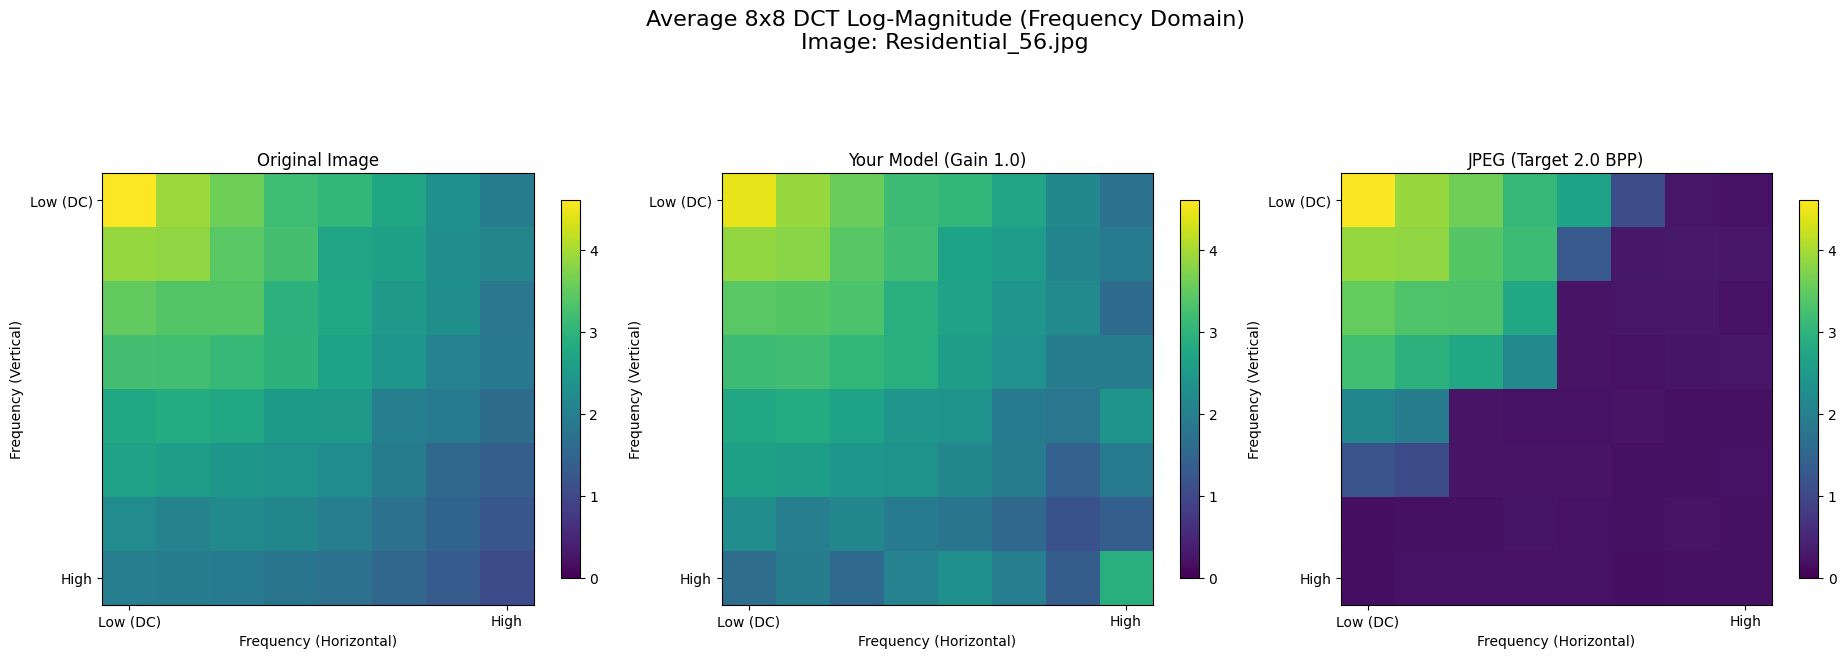

In [ ]:
# --- NEW CELL FOR DCT ANALYSIS ---
print("--- Starting DCT Frequency Analysis ---")

# --- 1. Imports for DCT ---
# Make sure scipy is installed: pip install scipy
try:
    from scipy.fftpack import dctn
except ImportError:
    print("Error: SciPy library not found.")
    print("Please install it by running: pip install scipy")
    # If in Jupyter/Colab, you might use: !pip install scipy
    raise

# --- 2. Helper Function for 8x8 Average DCT ---
def get_avg_dct_log(image_pil):
    """
    Computes the average magnitude of 8x8 DCT blocks from a PIL image
    and returns the log-scaled result for plotting.
    """
    # Convert to grayscale (Luminance) and center data around 0
    img_gray = image_pil.convert('L')
    img_np = np.array(img_gray).astype(float) - 128.0
    h, w = img_np.shape

    if h < 8 or w < 8:
        print(f"Warning: Image is smaller than 8x8 ({w}x{h}). DCT plot may be misleading.")
        # Fallback for tiny images: just take DCT of the top-left corner
        block = img_np[:min(h, 8), :min(w, 8)]
        # Pad to 8x8 if necessary
        if block.shape[0] < 8 or block.shape[1] < 8:
            padded_block = np.zeros((8, 8))
            padded_block[:block.shape[0], :block.shape[1]] = block
            block = padded_block

        block_dct = dctn(block, norm='ortho')
        return np.log(1 + np.abs(block_dct))

    total_dct_mag = np.zeros((8, 8))
    block_count = 0

    # Iterate over all 8x8 blocks
    for r in range(0, h - 7, 8): # Step by 8
        for c in range(0, w - 7, 8): # Step by 8
            block = img_np[r:r+8, c:c+8]

            # Apply 2D DCT (Discrete Cosine Transform)
            block_dct = dctn(block, norm='ortho')

            # Accumulate the absolute magnitude
            total_dct_mag += np.abs(block_dct)
            block_count += 1

    if block_count == 0:
         print("Warning: No full 8x8 blocks were found.")
         return np.log(1 + total_dct_mag) # Will be zeros

    # Average the magnitudes
    avg_dct_mag = total_dct_mag / block_count

    # We use log scale because the DC component (top-left)
    # is thousands of times larger than the AC components.
    return np.log(1 + avg_dct_mag)

# --- 3. Run Analysis on the *First* Test Image ---
# This code assumes your previous cell has been run and these variables exist:
# - test_images, TEST_PATH
# - inference_model, device, test_transforms, gain_tensor
# - get_jpeg_at_bpp, TARGET_BPP_JPEG

try:
    # Get the first image from your test list
    if not test_images:
        raise NameError("The 'test_images' list is empty or was not created.")

    first_image_name = test_images[0]
    first_image_path = os.path.join(TEST_PATH, first_image_name)

    print(f"Analyzing DCT for: {first_image_name}")

    # --- Get the 3 required images (in PIL format) ---

    # 1. Original Image
    original_pil = Image.open(first_image_path).convert("RGB")
    original_tensor = test_transforms(original_pil).unsqueeze(0).to(device)
    num_pixels = original_tensor.size(2) * original_tensor.size(3)

    # 2. Model Reconstructed Image
    with torch.no_grad():
        output_dict = inference_model(original_tensor, gain_tensor)
        recon_model_tensor = output_dict["x_hat"].clamp_(0, 1)

    # Convert model's output tensor back to a PIL Image
    tensor_to_pil = transforms.ToPILImage()
    model_pil = tensor_to_pil(recon_model_tensor.squeeze(0).cpu())

    # 3. JPEG Reconstructed Image
    jpeg_pil, _, _ = get_jpeg_at_bpp(original_pil, TARGET_BPP_JPEG, num_pixels)

    # --- 4. Calculate DCT for all three ---
    dct_original = get_avg_dct_log(original_pil)
    dct_model = get_avg_dct_log(model_pil)
    dct_jpeg = get_avg_dct_log(jpeg_pil)

    # --- 5. Plot the DCTs ---
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 7))
    fig.suptitle(f'Average 8x8 DCT Log-Magnitude (Frequency Domain)\nImage: {first_image_name}', fontsize=16)

    # Use a common color scale based on the original image's max frequency
    v_max = np.max(dct_original)
    v_min = 0

    # Plotting helper
    def plot_dct(ax, data, title):
        # Use 'viridis' colormap, show colorbar
        im = ax.imshow(data, cmap='viridis', vmin=v_min, vmax=v_max)
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('Frequency (Horizontal)')
        ax.set_ylabel('Frequency (Vertical)')
        # Top-left is (0,0) DC component
        ax.set_xticks([0, 7])
        ax.set_xticklabels(['Low (DC)', 'High'])
        ax.set_yticks([0, 7])
        ax.set_yticklabels(['Low (DC)', 'High'])
        fig.colorbar(im, ax=ax, shrink=0.7) # Add color bar

    plot_dct(ax1, dct_original, "Original Image")
    plot_dct(ax2, dct_model, f"Your Model (Gain {TARGET_GAIN:.1f})")
    plot_dct(ax3, dct_jpeg, f"JPEG (Target {TARGET_BPP_JPEG:.1f} BPP)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.savefig("dct_comparison.png")
    print("\nSaved DCT comparison plot to dct_comparison.png")
    plt.show()

except NameError as e:
    print(f"\n---! ERROR !---")
    print(f"Could not run DCT analysis. Make sure you have run the *previous cell* first.")
    print(f"A required variable was not found: {e}")
except Exception as e:
    print(f"\n---! ERROR During DCT Analysis !---")
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

--- Starting Full-Image DCT Frequency Analysis ---
Analyzing DCT for: Residential_56.jpg

Saved full-image DCT comparison plot to full_dct_comparison.png


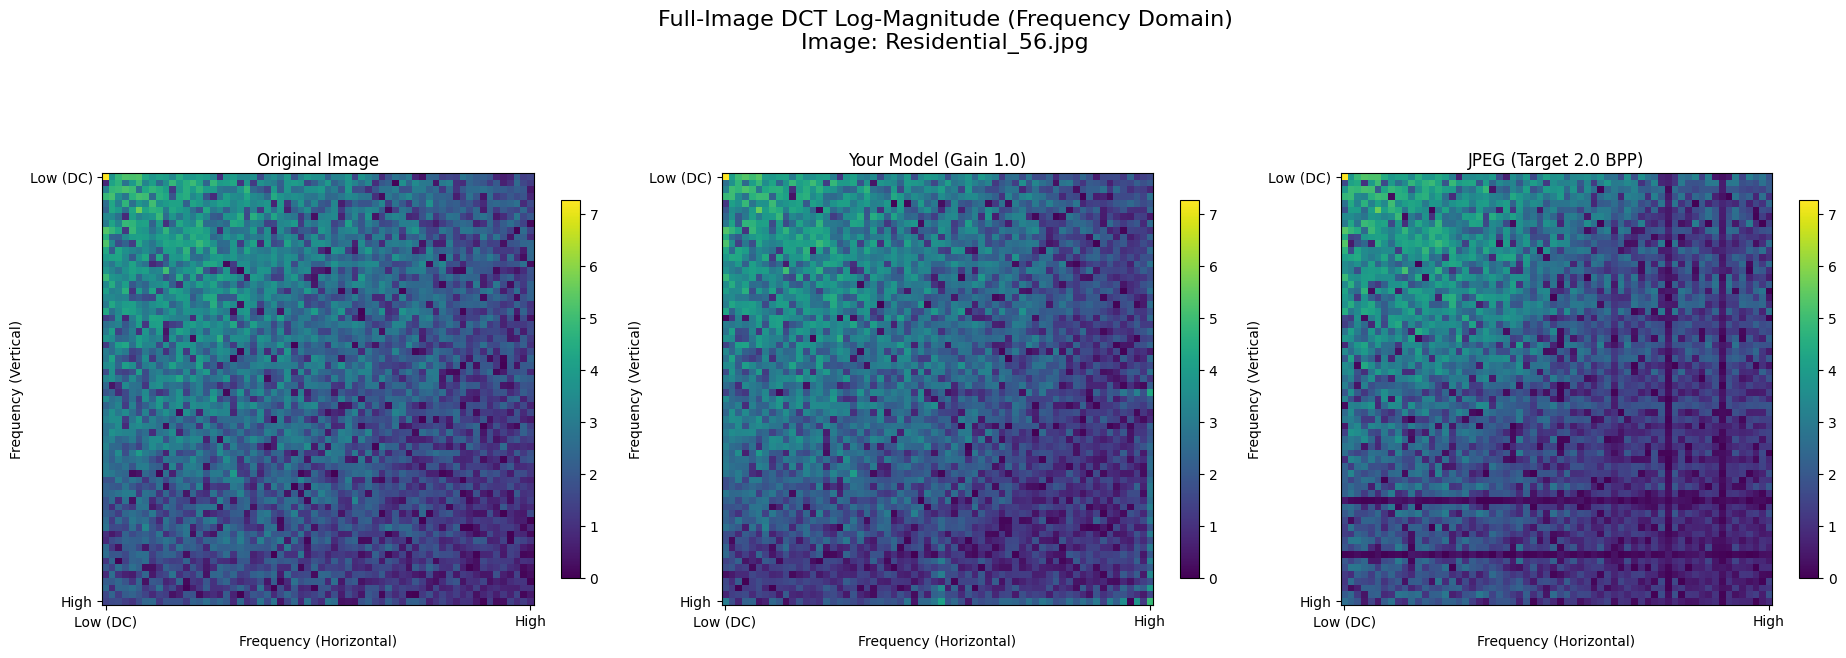

In [ ]:
# --- NEW CELL FOR FULL-IMAGE DCT ANALYSIS ---
print("--- Starting Full-Image DCT Frequency Analysis ---")

# --- 1. Imports ---
try:
    from scipy.fftpack import dctn
except ImportError:
    try:
        from scipy.fft import dctn # Newer scipy path
    except ImportError:
        print("Error: SciPy library not found.")
        print("Please install it by running: pip install scipy")
        raise

# --- 2. Helper Function for Full-Image DCT ---
def get_full_image_dct_log(image_pil):
    """
    Computes the 2D DCT of the entire image (luminance channel)
    and returns the log-scaled magnitude.
    """
    # Convert to grayscale (Luminance) and as a numpy array
    img_gray_np = np.array(image_pil.convert('L')).astype(float)

    # Apply 2D DCT (Discrete Cosine Transform)
    # norm='ortho' ensures the transform is orthogonal
    dct_coeffs = dctn(img_gray_np, norm='ortho')

    # We use log scale because the DC component (top-left [0,0])
    # is vastly larger than all other frequency components.
    # np.log1p is equivalent to np.log(1 + x), avoiding log(0) errors.
    return np.log1p(np.abs(dct_coeffs))

# --- 3. Run Analysis on the *First* Test Image ---
# This code assumes your *very first* cell has been run and these variables exist:
# - test_images, TEST_PATH
# - inference_model, device, test_transforms, gain_tensor
# - get_jpeg_at_bpp, TARGET_BPP_JPEG

try:
    # Get the first image from your test list
    if not test_images:
        raise NameError("The 'test_images' list is empty or was not created.")

    first_image_name = test_images[0]
    first_image_path = os.path.join(TEST_PATH, first_image_name)

    print(f"Analyzing DCT for: {first_image_name}")

    # --- Get the 3 required images (in PIL format) ---

    # 1. Original Image
    original_pil = Image.open(first_image_path).convert("RGB")
    original_tensor = test_transforms(original_pil).unsqueeze(0).to(device)
    num_pixels = original_tensor.size(2) * original_tensor.size(3)

    # 2. Model Reconstructed Image
    with torch.no_grad():
        output_dict = inference_model(original_tensor, gain_tensor)
        recon_model_tensor = output_dict["x_hat"].clamp_(0, 1)

    tensor_to_pil = transforms.ToPILImage()
    model_pil = tensor_to_pil(recon_model_tensor.squeeze(0).cpu())

    # 3. JPEG Reconstructed Image
    jpeg_pil, _, _ = get_jpeg_at_bpp(original_pil, TARGET_BPP_JPEG, num_pixels)

    # --- 4. Calculate DCT for all three ---
    full_dct_original = get_full_image_dct_log(original_pil)
    full_dct_model = get_full_image_dct_log(model_pil)
    full_dct_jpeg = get_full_image_dct_log(jpeg_pil)

    # --- 5. Plot the DCTs ---
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 7))
    fig.suptitle(f'Full-Image DCT Log-Magnitude (Frequency Domain)\nImage: {first_image_name}', fontsize=16)

    # Use a common color scale based on the original image's max frequency
    v_max = np.max(full_dct_original) * 0.8 # Clamp max color for better visibility
    v_min = 0

    # Plotting helper
    def plot_full_dct(ax, data, title):
        im = ax.imshow(data, cmap='viridis', vmin=v_min, vmax=v_max)
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('Frequency (Horizontal)')
        ax.set_ylabel('Frequency (Vertical)')

        # Top-left is (0,0) DC component (low frequency)
        ax.set_xticks([0, data.shape[1]-1])
        ax.set_xticklabels(['Low (DC)', 'High'])
        ax.set_yticks([0, data.shape[0]-1])
        ax.set_yticklabels(['Low (DC)', 'High'])
        fig.colorbar(im, ax=ax, shrink=0.7)

    plot_full_dct(ax1, full_dct_original, "Original Image")
    plot_full_dct(ax2, full_dct_model, f"Your Model (Gain {TARGET_GAIN:.1f})")
    plot_full_dct(ax3, full_dct_jpeg, f"JPEG (Target {TARGET_BPP_JPEG:.1f} BPP)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.savefig("full_dct_comparison.png")
    print("\nSaved full-image DCT comparison plot to full_dct_comparison.png")
    plt.show()

except NameError as e:
    print(f"\n---! ERROR !---")
    print(f"Could not run DCT analysis. Make sure you have run the *evaluation cell* first.")
    print(f"A required variable was not found: {e}")
except Exception as e:
    print(f"\n---! ERROR During DCT Analysis !---")
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

--- Generating Rate-Distortion (RD) Curve ---
Using image: Residential_56.jpg
Evaluating Model...
  Gain 0.10: BPP=1.4864, PSNR=16.98dB
  Gain 0.25: BPP=1.4588, PSNR=24.49dB
  Gain 0.50: BPP=1.5542, PSNR=27.63dB
  Gain 1.00: BPP=1.9467, PSNR=28.91dB
  Gain 2.00: BPP=3.8210, PSNR=29.49dB
  Gain 4.00: BPP=12.8910, PSNR=29.56dB
  Gain 8.00: BPP=25.2968, PSNR=29.58dB

Evaluating JPEG...
  Target BPP 0.10 (Q=1): Actual BPP=1.3691, PSNR=19.93dB
  Target BPP 0.20 (Q=1): Actual BPP=1.3691, PSNR=19.93dB
  Target BPP 0.40 (Q=1): Actual BPP=1.3691, PSNR=19.93dB
  Target BPP 0.60 (Q=1): Actual BPP=1.3691, PSNR=19.93dB
  Target BPP 1.00 (Q=1): Actual BPP=1.3691, PSNR=19.93dB
  Target BPP 1.50 (Q=5): Actual BPP=1.4688, PSNR=21.84dB
  Target BPP 2.00 (Q=18): Actual BPP=1.9805, PSNR=25.88dB

Saved RD-Curve plot to rate_distortion_curve.png


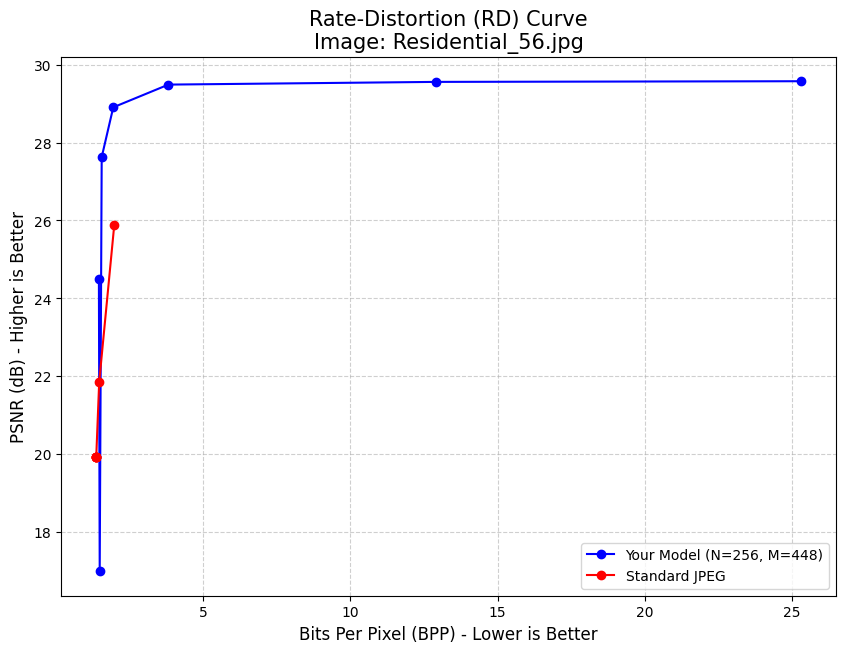

In [ ]:
# --- NEW CELL FOR RATE-DISTORTION (RD) CURVE ---
print("--- Generating Rate-Distortion (RD) Curve ---")

# This code assumes all your initial setup cells have been run
# (model loaded, helper functions defined, etc.)

# --- 1. Define quality levels to test ---
# More points = smoother curve
model_gains = [0.1, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]
jpeg_bpp_targets = [0.1, 0.2, 0.4, 0.6, 1.0, 1.5, 2.0]

# --- 2. Get the first test image ---
try:
    if not test_images:
        raise NameError("The 'test_images' list is empty or was not created.")

    first_image_name = test_images[0]
    first_image_path = os.path.join(TEST_PATH, first_image_name)

    print(f"Using image: {first_image_name}")

    original_pil = Image.open(first_image_path).convert("RGB")
    original_tensor = test_transforms(original_pil).unsqueeze(0).to(device)
    num_pixels = original_tensor.size(2) * original_tensor.size(3)

    # --- 3. Storage for plot points ---
    model_rd_points = [] # (bpp, psnr)
    jpeg_rd_points = [] # (bpp, psnr)

    # --- 4. Evaluate Your Model at different gains ---
    print("Evaluating Model...")
    with torch.no_grad():
        for gain in model_gains:
            gain_tensor = torch.tensor([gain]).view(1, 1, 1, 1).to(device)

            output_dict = inference_model(original_tensor, gain_tensor)
            recon_tensor = output_dict["x_hat"].clamp_(0, 1)

            # Calculate PSNR
            psnr_val = compute_psnr(recon_tensor, original_tensor)

            # Calculate BPP (using your BPP calculation logic)
            likelihoods = output_dict["likelihoods"]
            rate_y = torch.log(likelihoods["y"]).sum() / (-math.log(2) * num_pixels)
            rate_z = torch.log(likelihoods["z"]).sum() / (-math.log(2) * num_pixels)
            bpp_val = (rate_y + rate_z).item()

            model_rd_points.append((bpp_val, psnr_val))
            print(f"  Gain {gain:.2f}: BPP={bpp_val:.4f}, PSNR={psnr_val:.2f}dB")

    # --- 5. Evaluate JPEG at different BPP targets ---
    print("\nEvaluating JPEG...")
    for target_bpp in jpeg_bpp_targets:
        jpeg_pil, actual_bpp, jpeg_q = get_jpeg_at_bpp(original_pil, target_bpp, num_pixels)

        # Convert back to tensor for PSNR
        recon_jpeg_tensor = test_transforms(jpeg_pil).unsqueeze(0).to(device)

        # Calculate PSNR
        psnr_val = compute_psnr(recon_jpeg_tensor, original_tensor)

        jpeg_rd_points.append((actual_bpp, psnr_val))
        print(f"  Target BPP {target_bpp:.2f} (Q={jpeg_q}): Actual BPP={actual_bpp:.4f}, PSNR={psnr_val:.2f}dB")

    # --- 6. Sort for plotting ---
    model_rd_points.sort()
    jpeg_rd_points.sort()

    model_bpp_list = [p[0] for p in model_rd_points]
    model_psnr_list = [p[1] for p in model_rd_points]

    jpeg_bpp_list = [p[0] for p in jpeg_rd_points]
    jpeg_psnr_list = [p[1] for p in jpeg_rd_points]

    # --- 7. Plot the RD Curve ---
    plt.figure(figsize=(10, 7))
    plt.plot(model_bpp_list, model_psnr_list, 'bo-', label=f'Your Model (N={NUM_FILTERS_N}, M={NUM_FILTERS_M})')
    plt.plot(jpeg_bpp_list, jpeg_psnr_list, 'ro-', label='Standard JPEG')

    plt.title(f'Rate-Distortion (RD) Curve\nImage: {first_image_name}', fontsize=15)
    plt.xlabel('Bits Per Pixel (BPP) - Lower is Better', fontsize=12)
    plt.ylabel('PSNR (dB) - Higher is Better', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.savefig("rate_distortion_curve.png")
    print("\nSaved RD-Curve plot to rate_distortion_curve.png")
    plt.show()

except Exception as e:
    print(f"\n---! ERROR During RD-Curve Analysis !---")
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

Loading model from /content/drive/MyDrive/AI_Models/Images_project/Improvement_3/model.pth...
Successfully loaded best model weights.

Loading and resizing test image: Screenshot 2025-11-07 180644.png
Running model inference...
Running JPEG compression to match model BPP of 2.402...
Plotting comparison...
Saved plot to proof_of_concept_comparison.png


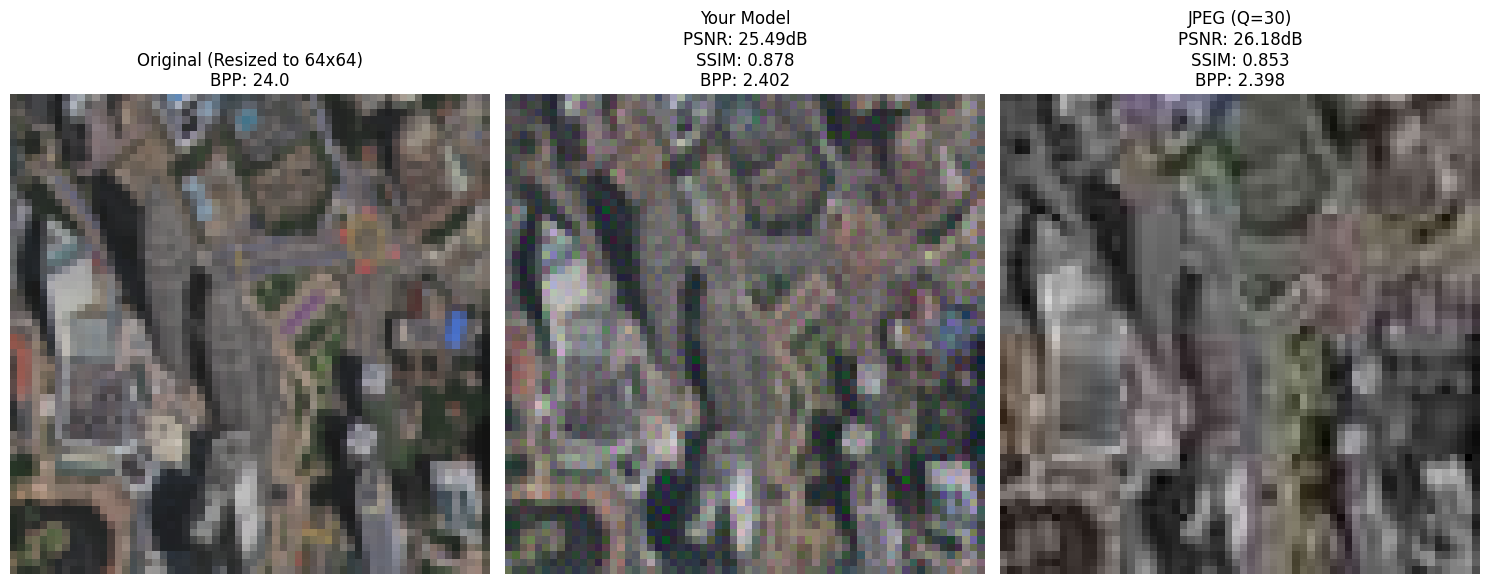

In [14]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import math
import torch.nn.functional as F
import pytorch_msssim
import io

# --- Helper function for PSNR (for tensors in [0, 1] range) ---
def compute_psnr(a, b):
    mse = torch.mean((a - b) ** 2).item()
    if mse == 0:
        return float('inf')
    return -10 * math.log10(mse)

# --- Helper function to get JPEG at a target BPP ---
def get_jpeg_at_bpp(image_pil, target_bpp, num_pixels):
    """
    Compresses a PIL image to JPEG, iteratively finding the highest
    quality (Q) that results in a BPP at or below the target_bpp.
    """
    target_bytes = (num_pixels * target_bpp) / 8.0

    for quality in range(100, 0, -1):
        buffer = io.BytesIO()
        image_pil.save(buffer, format="JPEG", quality=quality)
        file_size = buffer.tell()

        if file_size <= target_bytes:
            actual_bpp = (file_size * 8) / num_pixels
            jpeg_image_pil = Image.open(buffer)
            return jpeg_image_pil, actual_bpp, quality

    # Fallback for very low BPP targets
    buffer = io.BytesIO()
    image_pil.save(buffer, format="JPEG", quality=1)
    file_size = buffer.tell()
    actual_bpp = (file_size * 8) / num_pixels
    jpeg_image_pil = Image.open(buffer)
    return jpeg_image_pil, actual_bpp, 1

# --- 1. Define Parameters ---
device = "cuda" if torch.cuda.is_available() else "cpu"

# !! IMPORTANT: Set this to your folder with high-res images !!
HIGH_RES_TEST_PATH = "/content/drive/MyDrive/Collab_Data/high_quality_images" # <-- CHANGE THIS
SAVE_PATH = "/content/drive/MyDrive/AI_Models/Images_project/Improvement_3/model.pth"

# Model parameters from your notebook
NUM_FILTERS_N = 256
NUM_FILTERS_M = 448
TARGET_GAIN = 1.0 # Use 1.0 for a neutral comparison

# --- 2. Define Image Transforms (Using your definitions) ---
# For resizing the new PIL image
pil_resizer = transforms.Resize((64, 64))
# From your Cell 5, for converting PIL to Tensor
test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# --- 3. Load Model ---
# This assumes the SatelliteVBR class is defined above in your notebook
print(f"Loading model from {SAVE_PATH}...")
inference_model = SatelliteVBR(N=NUM_FILTERS_N, M=NUM_FILTERS_M).to(device)

try:
    state_dict = torch.load(SAVE_PATH, map_location=device)
    inference_model.load_state_dict(state_dict, strict=False)
    inference_model.eval()
    print("Successfully loaded best model weights.\n")

    # --- 4. Load ONE High-Res Image ---
    all_files = [f for f in os.listdir(HIGH_RES_TEST_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not all_files:
        raise FileNotFoundError(f"No images found in {HIGH_RES_TEST_PATH}. Please upload an image.")

    test_image_filename = all_files[0] # Get the first image
    test_image_path = os.path.join(HIGH_RES_TEST_PATH, test_image_filename)
    print(f"Loading and resizing test image: {test_image_filename}")

    high_res_pil = Image.open(test_image_path).convert("RGB")

    # --- 5. Prepare Images ---
    # 1. Create the 64x64 PIL version (for JPEG and display)
    resized_pil = pil_resizer(high_res_pil)

    # 2. Create the 64x64 Tensor version (for model and metrics)
    original_tensor = test_transforms(resized_pil).unsqueeze(0).to(device)

    num_pixels = original_tensor.size(2) * original_tensor.size(3)
    gain_tensor = torch.tensor([TARGET_GAIN]).view(1, 1, 1, 1).to(device)

    # --- 6. Run Model Inference ---
    print("Running model inference...")
    with torch.no_grad():
        output_dict = inference_model(original_tensor, gain_tensor)
        recon_image_model = output_dict["x_hat"].clamp_(0, 1)

        # Calculate metrics for Model
        model_psnr = compute_psnr(recon_image_model, original_tensor)
        model_ssim = pytorch_msssim.ssim(recon_image_model, original_tensor, data_range=1.0).item()

        likelihoods = output_dict["likelihoods"]
        rate_y = torch.log(likelihoods["y"]).sum() / (-math.log(2) * num_pixels)
        rate_z = torch.log(likelihoods["z"]).sum() / (-math.log(2) * num_pixels)
        model_bpp = (rate_y + rate_z).item()

    # --- 7. Run JPEG Comparison ---
    print(f"Running JPEG compression to match model BPP of {model_bpp:.3f}...")
    # Target the same BPP as the model
    jpeg_pil, jpeg_bpp, jpeg_q = get_jpeg_at_bpp(resized_pil, model_bpp, num_pixels)

    # Convert JPEG PIL image back to tensor for metrics
    recon_image_jpeg = test_transforms(jpeg_pil).unsqueeze(0).to(device)

    # Calculate metrics for JPEG
    jpeg_psnr = compute_psnr(recon_image_jpeg, original_tensor)
    jpeg_ssim = pytorch_msssim.ssim(recon_image_jpeg, original_tensor, data_range=1.0).item()

    # --- 8. Plot Results ---
    print("Plotting comparison...")
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))

    # Original (64x64)
    axes[0].imshow(resized_pil)
    axes[0].set_title(f"Original (Resized to 64x64)\nBPP: 24.0")
    axes[0].axis("off")

    # Model Reconstruction
    axes[1].imshow(recon_image_model.squeeze(0).cpu().permute(1, 2, 0).numpy())
    axes[1].set_title(f"Your Model\nPSNR: {model_psnr:.2f}dB\nSSIM: {model_ssim:.3f}\nBPP: {model_bpp:.3f}")
    axes[1].axis("off")

    # JPEG Reconstruction
    axes[2].imshow(jpeg_pil)
    axes[2].set_title(f"JPEG (Q={jpeg_q})\nPSNR: {jpeg_psnr:.2f}dB\nSSIM: {jpeg_ssim:.3f}\nBPP: {jpeg_bpp:.3f}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.savefig("proof_of_concept_comparison.png")
    print("Saved plot to proof_of_concept_comparison.png")

except FileNotFoundError:
    print(f"\n---! ERROR !---")
    print(f"Could not find model at {SAVE_PATH} or image at {HIGH_RES_TEST_PATH}")
    print("Please make sure you have created the folder, uploaded an image, and updated the HIGH_RES_TEST_PATH variable.")
except Exception as e:
    print(f"\n---! ERROR During Evaluation !---")
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

Loading high-res image: Screenshot 2025-11-07 180644.png
Image size: 465x568

--- Running Model (Gain=1.0) ---
  > Starting patch inference... Total patches: 238
  > Patch inference complete.
  > Model Metrics: BPP=14.0143, PSNR=25.81dB, SSIM=0.8620

--- Running JPEG (Target BPP=14.0143) ---
  > JPEG Metrics (Q=100): BPP=7.7387, PSNR=47.11dB, SSIM=0.9975

Plotting final high-res comparison...
Saved high-resolution comparison plot to high_res_patch_comparison.png


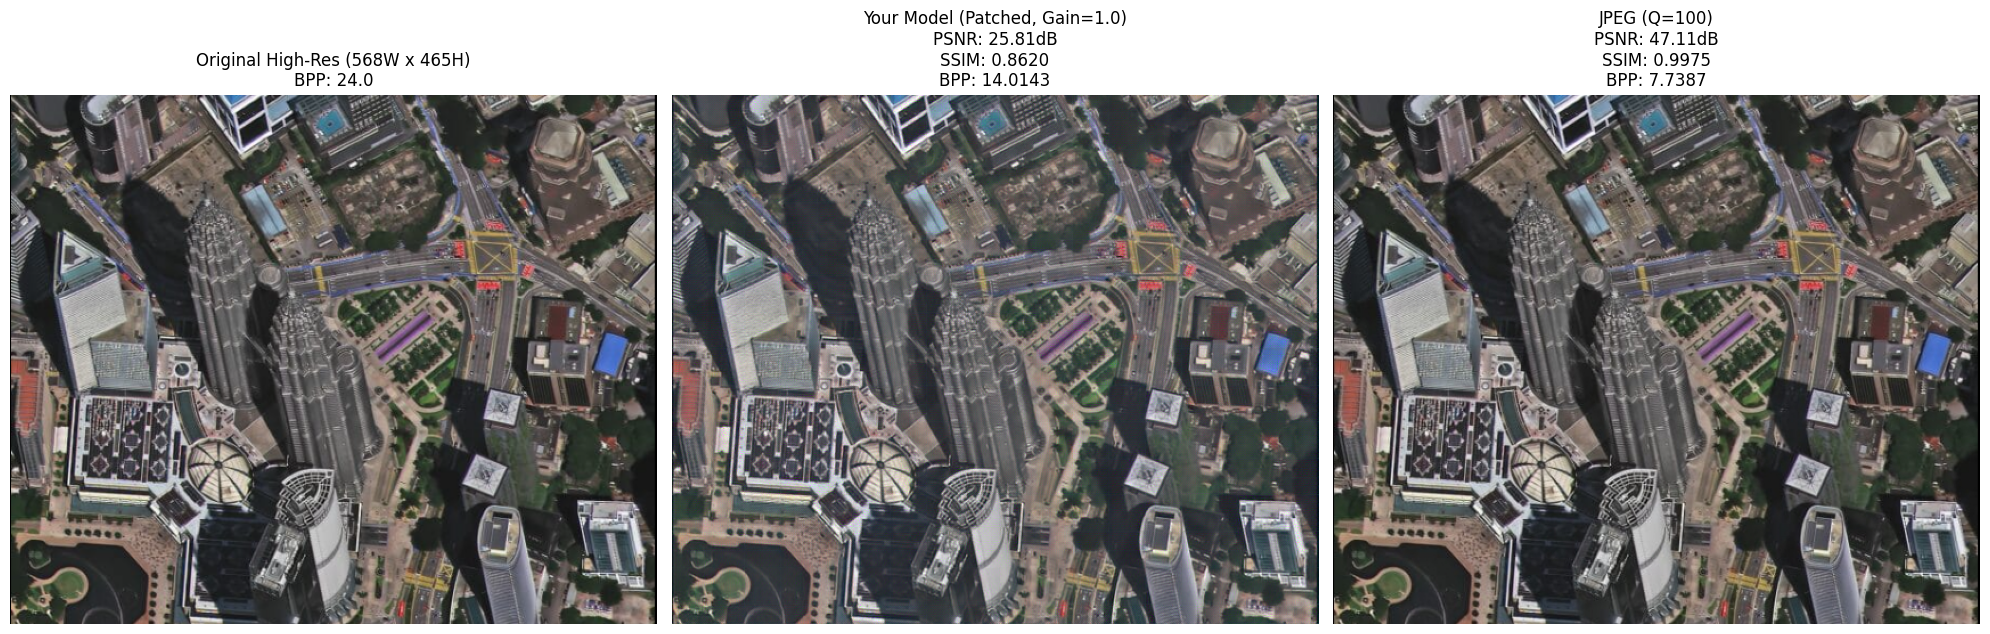

In [15]:
# --- [Make sure your imports, helper functions (compute_psnr, get_jpeg_at_bpp),
#      and the SatelliteVBR class definition are in a cell *above* this one] ---

# --- 1. Define Patch Inference Function ---
def run_inference_with_overlap(model, high_res_tensor, gain_tensor, patch_size=64, overlap=32):
    """
    Runs inference on a high-res image using overlapping patches
    and blends the results by averaging.

    Returns:
        - final_recon_tensor (torch.Tensor): The blended, reconstructed high-res image.
        - final_bpp (float): The true BPP for the entire image.
    """
    device = high_res_tensor.device
    B, C, H, W = high_res_tensor.shape
    stride = patch_size - overlap

    # 1. Create accumulators for the blended image and the weights
    # These will store the sum of pixel values and the count of overlaps
    accumulator = torch.zeros_like(high_res_tensor).to(device)
    weights = torch.zeros_like(high_res_tensor).to(device)

    # 2. To calculate BPP: sum total bits, divide by total pixels
    total_bits = 0
    total_pixels_in_image = H * W

    # 3. Generate the patch start coordinates (r, c)
    # We ensure we get patches flush to the bottom and right edges
    r_steps = list(range(0, H - patch_size, stride)) + [H - patch_size]
    c_steps = list(range(0, W - patch_size, stride)) + [W - patch_size]

    # Remove duplicates if H or W is a multiple of patch_size
    r_steps = sorted(list(set(r_steps)))
    c_steps = sorted(list(set(c_steps)))

    num_patches = len(r_steps) * len(c_steps)
    print(f"  > Starting patch inference... Total patches: {num_patches}")

    with torch.no_grad():
        for i, r in enumerate(r_steps):
            for j, c in enumerate(c_steps):
                # 4. Extract the 64x64 patch
                r_end, c_end = r + patch_size, c + patch_size
                patch = high_res_tensor[..., r:r_end, c:c_end]

                # 5. Run inference on the patch
                output_dict = model(patch, gain_tensor)
                recon_patch = output_dict["x_hat"].clamp_(0, 1)

                # 6. Add the reconstructed patch to the accumulator
                accumulator[..., r:r_end, c:c_end] += recon_patch

                # 7. Add '1' to the weights for this patch's area
                # This counts how many patches contributed to each pixel
                weights[..., r:r_end, c:c_end] += 1.0

                # 8. Accumulate the bits for BPP calculation
                likelihoods = output_dict["likelihoods"]
                num_pixels_patch = patch_size * patch_size
                rate_y = torch.log(likelihoods["y"]).sum() / (-math.log(2))
                rate_z = torch.log(likelihoods["z"]).sum() / (-math.log(2))
                total_bits += (rate_y + rate_z).item()

    # 9. Create the final image by dividing the sums by the overlap counts
    # This is the "blending" or "averaging" step
    final_recon_tensor = accumulator / weights

    # 10. Calculate the final, true BPP
    final_bpp = total_bits / total_pixels_in_image

    print(f"  > Patch inference complete.")
    return final_recon_tensor, final_bpp

# --- 2. Setup (Load Model and Image) ---
# This assumes 'inference_model' is already loaded and on 'device'
# This assumes 'HIGH_RES_TEST_PATH' is set
# This assumes 'test_transforms' is defined as just ToTensor()
try:
    # 1. Get the first high-res image
    all_files = [f for f in os.listdir(HIGH_RES_TEST_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not all_files:
        raise FileNotFoundError(f"No images found in {HIGH_RES_TEST_PATH}.")

    test_image_filename = all_files[0]
    test_image_path = os.path.join(HIGH_RES_TEST_PATH, test_image_filename)
    print(f"Loading high-res image: {test_image_filename}")

    high_res_pil = Image.open(test_image_path).convert("RGB")

    # 2. Create the HIGH-RES original tensor
    # We DO NOT resize this time.
    original_high_res_tensor = test_transforms(high_res_pil).unsqueeze(0).to(device)
    num_pixels_high_res = original_high_res_tensor.size(2) * original_high_res_tensor.size(3)
    gain_tensor = torch.tensor([TARGET_GAIN]).view(1, 1, 1, 1).to(device)

    print(f"Image size: {original_high_res_tensor.shape[2]}x{original_high_res_tensor.shape[3]}")

    # --- 3. Run Model Patch Inference ---
    print(f"\n--- Running Model (Gain={TARGET_GAIN}) ---")
    model_recon_high_res, model_bpp = run_inference_with_overlap(
        inference_model, original_high_res_tensor, gain_tensor, patch_size=64, overlap=32
    )

    # 4. Calculate Model Metrics
    model_psnr = compute_psnr(model_recon_high_res, original_high_res_tensor)
    model_ssim = pytorch_msssim.ssim(model_recon_high_res, original_high_res_tensor, data_range=1.0).item()
    print(f"  > Model Metrics: BPP={model_bpp:.4f}, PSNR={model_psnr:.2f}dB, SSIM={model_ssim:.4f}")

    # --- 5. Run JPEG "Fair Fight" Comparison ---
    print(f"\n--- Running JPEG (Target BPP={model_bpp:.4f}) ---")
    jpeg_pil_high_res, jpeg_bpp, jpeg_q = get_jpeg_at_bpp(
        high_res_pil, model_bpp, num_pixels_high_res
    )

    # 6. Calculate JPEG Metrics
    jpeg_tensor_high_res = test_transforms(jpeg_pil_high_res).unsqueeze(0).to(device)
    jpeg_psnr = compute_psnr(jpeg_tensor_high_res, original_high_res_tensor)
    jpeg_ssim = pytorch_msssim.ssim(jpeg_tensor_high_res, original_high_res_tensor, data_range=1.0).item()
    print(f"  > JPEG Metrics (Q={jpeg_q}): BPP={jpeg_bpp:.4f}, PSNR={jpeg_psnr:.2f}dB, SSIM={jpeg_ssim:.4f}")

    # --- 7. Plot High-Res Comparison ---
    print("\nPlotting final high-res comparison...")
    fig, axes = plt.subplots(1, 3, figsize=(20, 8)) # Larger figure size

    # 1. Original
    axes[0].imshow(high_res_pil)
    axes[0].set_title(f"Original High-Res ({original_high_res_tensor.size(3)}W x {original_high_res_tensor.size(2)}H)\nBPP: 24.0")
    axes[0].axis("off")

    # 2. Model
    # We need to convert the tensor back to PIL
    model_pil_high_res = transforms.ToPILImage()(model_recon_high_res.squeeze(0).cpu())
    axes[1].imshow(model_pil_high_res)
    axes[1].set_title(f"Your Model (Patched, Gain={TARGET_GAIN})\nPSNR: {model_psnr:.2f}dB\nSSIM: {model_ssim:.4f}\nBPP: {model_bpp:.4f}")
    axes[1].axis("off")

    # 3. JPEG
    axes[2].imshow(jpeg_pil_high_res)
    axes[2].set_title(f"JPEG (Q={jpeg_q})\nPSNR: {jpeg_psnr:.2f}dB\nSSIM: {jpeg_ssim:.4f}\nBPP: {jpeg_bpp:.4f}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.savefig("high_res_patch_comparison.png")
    print("Saved high-resolution comparison plot to high_res_patch_comparison.png")

except Exception as e:
    print(f"\n---! ERROR During High-Res Patch Evaluation !---")
    print(f"An error occurred: {e}")
    print("Check paths, class definitions, and that you have enough VRAM.")
    import traceback
    traceback.print_exc()